#### Mccall Model (1970) augmented with the following features:
1. Risk aversion
2. Job destruction
3. Job arrival rate

In [1]:
from scipy.stats import norm
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# By Sheng BI

Our worker maximizes her expected liftime utility. Again, we saving, so consumption is equal to income at each period.

\begin{eqnarray*}
\Sigma_{t=0}^{\infty} E[\beta\times u(y_{t})] \tag{1}
\end{eqnarray*}

$u$ represents worker's utility function, with standard assumptions on its shape: $u'>0$ and $u''<0$

Compared to the baseline model, we add the following features:
1. a job can be destructed at a rate $\alpha$
2. a job offer arrive at a rate $\gamma$

Recall that worker is either unemployed or employed. In the current context, we should explicitly define worker's value function in these two different states.

Let $V$ denote worker's value function when **unemployed**.

Let $E$ denote worker's value function when **employed**.

Now the value function can be written as follows:

\begin{eqnarray*}
E_{t+1} (w') = u(w') + \beta [(1-\alpha)E_{t} (w') + \alpha V_{t} ] \tag{2}
\end{eqnarray*}

\begin{eqnarray*}
V_{t+1} = u(b) +
    \beta (1 - \gamma) V_{t} +
    \beta \gamma \int_{w'} \max \{ V_{t}, E_{t}(w') \} F(w') \tag{3}
\end{eqnarray*}

The worker is then moving between the two states.

I am getting sloppy here. Mathematically, $E$ and $V$ are defined under $sup$. The $V$ is only attained when the worker makes optimal decision not only at present but at all future time points.


#### Implementation

We start by writing a beta-binomial distribution. This is a discrete distribution, so we could avoid integration.

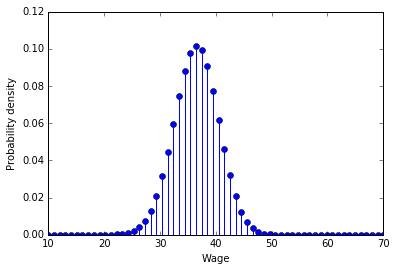

In [2]:
from scipy.special import beta
import operator as op
from functools import reduce

n = 60                              # number of possible outcomes for wage
w_vals = np.linspace(10, 70, n)     # wages between 10 and 20


def nck(n, k):
    '''
    choose k from n
    '''
    ## scipy.misc.comb also works.
    k = min(k, n-k)
    numer = reduce(op.mul, range(n, n-k, -1), 1)
    denom = reduce(op.mul, range(1, k+1), 1)
    return numer / denom

def beta_binom_pdf(k,n,a,b):
    pdf = nck(n,k) * beta(k+a, n-k+b)/beta(a,b)
    return pdf

wpdf_vals = map(lambda x: beta_binom_pdf(x,n=60, a= 600, b=400), np.int_(np.floor(w_vals)))

fig, ax = plt.subplots()

ax.stem(w_vals, wpdf_vals)
ax.set_xlabel("Wage")
ax.set_ylabel("Probability density")

In [3]:
my_beta, my_benefit = 0.99, 20 
my_alpha, my_gamma = 0.2, 0.5

class MccallModel():
    def __init__(self, beta = my_beta, benefit = my_benefit,\
                alpha = my_alpha, gamma = my_gamma):
        self.beta = beta
        self.benefit = benefit
        self.alpha = my_alpha
        self.gamma = my_gamma
        return

class Utility():
        def __init__(self, utility_type = 0):
            self.type = utility_type
                   
        def utility(self, c, s=0.2):
            if self.type == 0:
                return np.log(c)
            elif self.type == 1:
                return (c**(1-s) - 1)/ (1-s)

class ValueFunction(MccallModel):
    def __init__(self,beta = my_beta, benefit = my_benefit,\
                alpha = my_alpha, gamma = my_gamma):
        self.vCurrent = 1
        self.vNext    = 1
        self.eCurrent = w_vals/(1-my_beta)
        self.eNext    = np.empty_like(w_vals)
        return

vf = ValueFunction()        
mc = MccallModel()
ut = Utility()
# vf.vCurrent

In [4]:
def operator_T(e, v):
    
    vf.eNext = map(lambda w: ut.utility(w, s=0.2), w_vals) + \
                   mc.beta * ((1-mc.alpha) * e + mc.alpha * np.ones_like(e) * v)
    
    vf.vNext = \
    ut.utility(mc.benefit, s=0.2) + mc.beta * (1-mc.gamma) * v + \
    mc.beta * (mc.gamma) * np.sum(np.multiply(np.maximum(e, v), wpdf_vals))
    return vf.eNext, vf.vNext
    

def solve_model(tol=1e-6, num_iters=2000):
    
    vf = ValueFunction() 
    
    i,error = 0, 10
    
    eIter_process = []
    vIter_process = []

    while i< num_iters and error > tol:
        e_new, v_new = operator_T(vf.eCurrent, vf.vCurrent)
        error_e = np.max(np.abs(e_new - vf.eCurrent))
        error_v = np.abs(v_new - vf.vCurrent)
        error = max(error_e, error_v)
        
        vf.eCurrent, vf.vCurrent = e_new, v_new
        
        if (i % 30 == 0):
            eIter_process.append(vf.eCurrent)
            vIter_process.append(vf.vCurrent)
            
        i += 1
        #print(i,)

    return e_new, v_new, eIter_process, vIter_process

vEmployed, vUnemployed, eIter, vIter = solve_model()


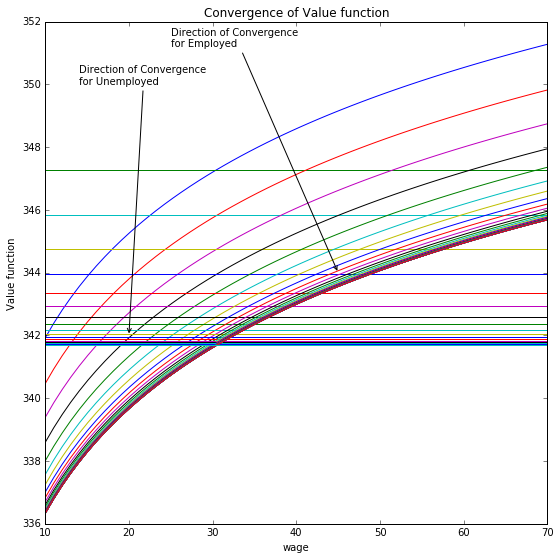

In [5]:
fig, ax = plt.subplots(figsize = (9,9))# plt.subplots(2, sharex= True)

for each in range(20, len(eIter)):
    ax.plot(w_vals, eIter[each], alpha = 1-(each/len(eIter)))
    ax.plot(w_vals, np.ones_like(w_vals)* vIter[each])
    
#ax.plot(w_vals, vEmployed)
# ax.plot(w_vals, vUnemployed*np.ones_like(vEmployed))
#ax.legend(['Employed', 'Unemployed'])
ax.set_title("Convergence of Value function")
ax.set_xlabel("wage")
ax.set_ylabel("Value function")
# ax.arrow(x=15, y= 351, dx = 0, dy = -10,arrowprops=dict(arrowstyle="->"))
ax.annotate("Direction of Convergence \nfor Employed", xy=(45, 344), xytext=(25, 351.2),arrowprops=dict(arrowstyle="->"))
ax.annotate("Direction of Convergence \nfor Unemployed", xy=(20, 342), xytext=(14, 350),arrowprops=dict(arrowstyle="->"))

#### Solving Reservation Wage

In the steady state, $V$ and $E$ no longer vary. So that we have, for all $w'$

\begin{eqnarray*}
E(w') = u(w') + \beta [(1-\alpha) E(w') + \alpha V ] \tag{4}
\end{eqnarray*}

\begin{eqnarray*}
V = u(b) +
    \beta (1 - \gamma) V +
    \beta \gamma \int_{w'} \max \{ V, E(w') \} F(w') \tag{5}
\end{eqnarray*}

If the support of $w$ satisfies $w\in \{w_{1}, w_{2} , ..., w_{N}\}$, then in the steady state, we have $N+1$ simultaneous equations, with $N$ equations $E(w)$ for different values of $w$ and 1 equation for $V$.

As could be seen (5). The reservation wage is the lowest level of wage which statisfies $E(w) \geq V$

In [6]:
def rsw(e = vEmployed,v = vUnemployed):
    diff = vEmployed - vUnemployed
    for index in range(0, len(diff)):
        if index <len(diff)-1:
            if diff[index]<0 and diff[index+1]>0:
                return index
print("The reservation wage is {0}, \nit is the {1}th order in the wage array".format(w_vals[rsw()], rsw()))

The reservation wage is 30.3389830508, 
it is the 20th order in the wage array


#### Law of Motion of Unemployment

\begin{eqnarray*}
x_{t+1} = \gamma x_{t} + (1-\gamma) (F(R) x_{t}) + (1-\alpha) y_{t} \tag{6}
\end{eqnarray*}

\begin{eqnarray*}
y_{t+1} = \alpha y_{t} + (1-\gamma) (1-F(R)) x_{t}  \tag{7}
\end{eqnarray*}

\begin{eqnarray*}
y_{t} + x_{t} = 1  \tag{8}
\end{eqnarray*}

Solving the system, we obtain:

\begin{eqnarray*}
y = \frac{1}{1 + \frac{1-\alpha} {(1-\gamma)(1-F(R))}}  \tag{9}
\end{eqnarray*}

\begin{eqnarray*}
x = 1-y \tag{10}
\end{eqnarray*}

In [7]:
#### Compute equilibrium unemployment rate.

unemployment_rate = 1 - 1/(1+(1-mc.alpha)/((1-mc.gamma)*(1-wpdf_vals[20])))

print(unemployment_rate)

0.622894983297648


### Reference:
1. https://lectures.quantecon.org/py/mccall_model_with_separation.html

2. http://users.econ.umn.edu/~tkehoe/classes/UnemploymentSearch.pdf

3. https://economics.mit.edu/files/10284